# Data Science Bowl 2018
@edwardp17 @edgarpavlovsky 

# Import libraries, configure, set parameters

Import libraries:

In [1]:
import warnings
import random
import os

# consider from skimage.io import imread, imshow, imread_collection, concatenate_images
# consider imageio
from PIL import Image
from skimage.transform import resize
from skimage.io import imshow

import numpy as np
import pandas as pd
import pathlib

import matplotlib.pyplot as plt

Configure:

In [2]:
% matplotlib inline

In [3]:
#warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Set parameters:

In [4]:
# set parameters
# We can use `IMG_WIDTH` and `IMG_HEIGHT` to downsize the images
# if we need to, but we're not going to yet.
# IMG_WIDTH = 128
# IMG_HEIGHT = 128

# Images actually have 3 channels.
# We grayscale below. Consider moving back up to 3 channels.
# IMG_CHANNELS = 3

# NOTE: If we run this notebook on Kaggle,
#  'data' in the paths needs to be changed to '../input/'
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

View a sample image:

In [6]:
im_id = str(train_ids[45])
im_full_path = TRAIN_PATH + im_id +'/images/'+ im_id +'.png'

In [7]:
im = Image.open(im_full_path)
arr_im = np.asarray(im)

In [11]:
arr_im[:3]

array([[[  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        ..., 
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]],

       [[  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        ..., 
        [  1,   1,   1, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255]],

       [[  2,   2,   2, 255],
        [  2,   2,   2, 255],
        [  2,   2,   2, 255],
        ..., 
        [  1,   1,   1, 255],
        [  1,   1,   1, 255],
        [  1,   1,   1, 255]]], dtype=uint8)

In [12]:
# Print the image dimensions
print('Original image shape: {}'.format(arr_im.shape))

# from skimage.color import rgb2gray
# im_gray = rgb2gray(im)
# print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)


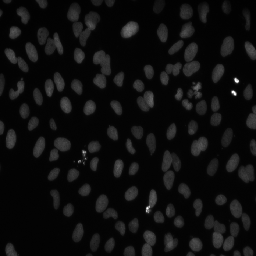

In [13]:
im.resize((256,256))

# Get data

In [25]:
def load_data(ids,path,training_data,im_folder='images',\
              mask_folder='masks',im_file_type='.png',\
             im_dim_1=520,im_dim_2=696,im_dim_3=4):
    
    # ids: the array of image ids
    # path: the general directory path, e.g. TRAIN_PATH or TEST_PATH
    # training data: a boolean that specifies whether the data being loaded is training data
    # im_folder: the image subfolder
    # mask_folder: the mask subfolder
    # im_file_type: the image file type. an assumption is made that
    #  the file type is the same for every image.
    # im_dim_1: the first standardization dimension to convert images to.
    # im_dim_2: the second standardization dimension to convert images to.
    # im_dim_3: the third standardization dimension to convert images to.
    
    # initialize empty lists
    X = []
    if training_data: y = []
    
    # print progress
    print(str(len(ids))+' images to load. This may take a while!')
    print('Loading dataset..')

    for i in range(len(ids)):
        # print progress metrics in notebook
        if i % 10 == 0 and i != 0:
            print(str(i)+'/'+str(len(ids))+' images loaded..')
        
        i = ids[i]
        
        # general directory path
        dir_path = path+i
        
        # load image
        im = Image.open(dir_path+'/'+im_folder+'/'+i+im_file_type)
        arr_im = np.asarray(im)
        
        # resize the image to standardize dimensions
        # TODO: Check if `mode` indeed needs to be 'constant' here
        arr_im = resize(arr_im, (im_dim_1,im_dim_2,im_dim_3),\
                        mode='constant', preserve_range=True)
        
        # add numpy image array to X list
        X.append(arr_im)
        
        if training_data:

            # TODO: double check that we want np.bool here
            arr_full_mask = np.zeros((im_dim_1,im_dim_2,im_dim_3),\
                                     dtype=np.bool)

            # BONUS_TODO: [2] in for statement below could be dynamic
            for mask_file in next(os.walk(dir_path+'/'+mask_folder+'/'))[2]:
                # load a mask
                im_mask = Image.open(dir_path+'/'+mask_folder+'/'+mask_file)
                # convert mask from image to array
                arr_mask = np.asarray(im_mask)
                # overlay this mask over every other mask for this image.
                # given the nuclei areas are white and
                # the areas with no nuclei are black, we can
                # use np.maximum() here.
                # first, we standardize the dimensions of the mask so it
                # fits the image.
                arr_mask = resize(arr_mask,(im_dim_1,im_dim_2,\
                                                          im_dim_3),\
                                                mode='constant',\
                                                preserve_range=True)

                arr_full_mask = np.maximum(arr_full_mask,arr_mask)

            y.append(arr_full_mask)
    
    return X, y

Load training data:

In [26]:
X_train, y_train = load_data(ids=train_ids,\
                             path=TRAIN_PATH,\
                            training_data=True)

670 images to load. This may take a while!
Loading dataset..
10/670 images loaded..
20/670 images loaded..
30/670 images loaded..
40/670 images loaded..
50/670 images loaded..
60/670 images loaded..
70/670 images loaded..
80/670 images loaded..


KeyboardInterrupt: 

Check if things look good by looking at a random image and its corresponding mask:

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Create our PyTorch loss metric
We need to define the loss metric our model will seek to minimize. This should follow the loss metric that is outlined in the competition.

Helpful links:
- [Competition Evaluation Page](https://www.kaggle.com/c/data-science-bowl-2018#evaluation)
- [A helpful notebook I've been referencing that walks through a Keras model, including defining a loss metric](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855)
- [A 60-minute PyTorch Blitz tutorial that walks through a simple image classification model](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

# Design our PyTorch model

# Train and implement the model

# Appendix
Saving things for quick reference later. This section is largely a mess.

NOTE: Don't run this stuff, it's not guarenteed to work.

In [ ]:
import pathlib
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
% matplotlib inline

In [ ]:
# Glob the training data and load a single image path
training_paths = pathlib.Path('data/stage1_train/').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])

In [ ]:
im_path = training_sorted[45]

In [ ]:
im_path

In [ ]:
im = imageio.imread(str(im_path))

In [ ]:
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

In [ ]:
# Apply Otsu method to convert images to have bimodal distributions

from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

In [ ]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

In [ ]:
label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

In [ ]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

In [ ]:
# Get the object indices, and perform a binary opening procedure
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

In [ ]:
cell_mask_opened

In [ ]:
imgplot = plt.imshow(cell_mask_opened)